In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud


# • Loading the data from imdb-reviews_2.csv file

In [3]:
df = pd.read_csv('imdb-reviews_2.csv')
df.head()

,review,label
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


# Number of positive and negative sentiments

In [5]:
positive = df['label'].value_counts()[1]
negative = df['label'].value_counts()[0]
print(f'positive count is {positive}')
print(f'negative count is {negative}')

positive count is 2528
negative count is 2472


Clean the text ‘review’ and create a column called ‘review_processed’

Replace short words as df['review_processed'] = df['review_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

    • Make entire text lowercase
    • Remove stopwords
    • Make custom list of words to be removed including ‘movie’, ‘film’, ‘one’, ‘make’, and ‘even’
    • Add to the list of words

In [6]:
df['review_processed'] = df['review'].str.lower()
df['review_processed'] = df['review_processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['review_processed'] = df['review_processed'].apply(lambda x: ' '.join([w for w in word_tokenize(x) if w not in stop_words]))

# Making a custom list of words to be removed including below custom_stop_words
custom_stop_words = ['movie', 'film', 'one', 'make', 'even']
df['review_processed'] = df['review_processed'].apply(lambda x: ' '.join([w for w in x.split() if w not in custom_stop_words]))

Lemmatize the text

In [7]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Convert NLTK tags into ‘wordnet’ tags
    • Find the part of speech tag
    • Lemmatize sentences using POS. Tokenize the sentence and find POS tag for each token

In [9]:
def wordnet_tagged(sentence):
    tokens = word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged]
    return ' '.join(lemmatized_tokens)

Define **‘wordnet_tagged.’**

If there is no available tag, append the token as is. Else, use the tag to lemmatize the token


In [10]:
df['review_processed'] = df['review_processed'].apply(wordnet_tagged)

all_words = ' '.join(df['review_processed']).split()
word_freq = nltk.FreqDist(all_words)

Plot the most frequent words from positive reviews using bar chart.

Subset positive review dataset, extract words into list and count frequency.

Subset top 30 words by frequency in a horizontal bar chart

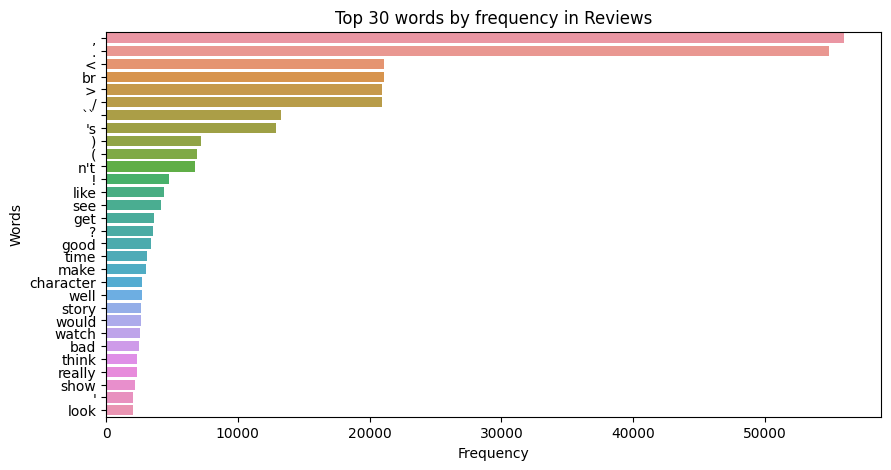

In [11]:
plt.figure(figsize=(10, 5))
sns.barplot(x=[word[1] for word in word_freq.most_common(30)], y=[word[0] for word in word_freq.most_common(30)])
plt.title('Top 30 words by frequency in Reviews')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


# Create a word cloud

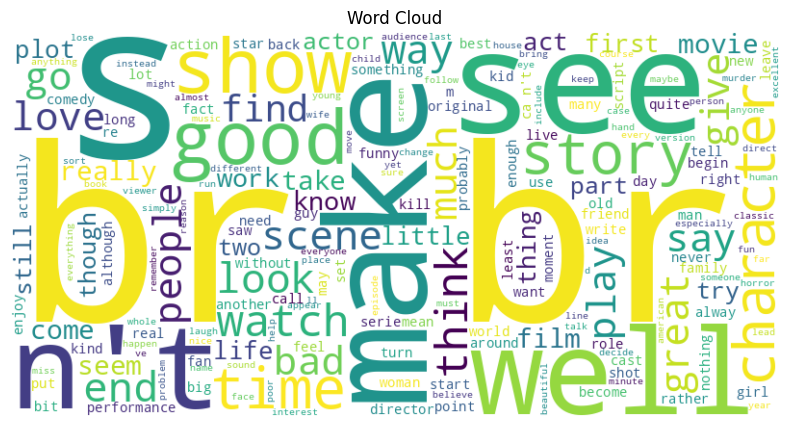

In [12]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

Import CountVectorizer and create a sparse matrix of 2,500 tokens.

Split the data set into train and test (20%) set

In [13]:
vectorizer = CountVectorizer(max_features=2500)
X = vectorizer.fit_transform(df['review_processed'])

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

Use the GaussianNB to train the model on the training data. Provide the accuracy of the model

In [14]:
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
y_pred = gnb.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of GNB:", accuracy)

Accuracy of GNB: 0.701


Test the model on the test set

    • Create the confusion matrix and classification report

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[400  79]
 [220 301]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.84      0.73       479
           1       0.79      0.58      0.67       521

    accuracy                           0.70      1000
   macro avg       0.72      0.71      0.70      1000
weighted avg       0.72      0.70      0.70      1000



Use Seaborn heatmap to show TP, FP, TN, FN values

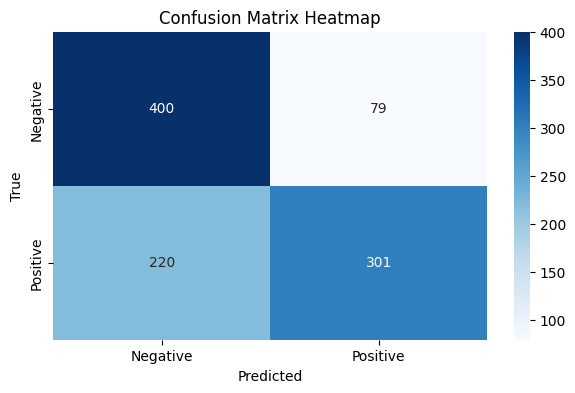

In [16]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Use a logistic regression model and check the accuracy of the model for C=0.01, 0.05, 0.5, 0.5, and 1.

In [17]:
Cs = [0.01, 0.05, 0.5, 1]
for C in Cs:
    lr = LogisticRegression(C=C, max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    print(f"Accuracy of Logistic Regression (C={C}): {accuracy_lr}")

Accuracy of Logistic Regression (C=0.01): 0.849
Accuracy of Logistic Regression (C=0.05): 0.853
Accuracy of Logistic Regression (C=0.5): 0.838
Accuracy of Logistic Regression (C=1): 0.831


# Provide the ROC curve. What is the area under the curve?

In [18]:
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
print("Area under the curve is", roc_auc)

Area under the curve is 0.9001598820319042
